# Data-pipeline simple example
Using syntethic data that's allready fairly clean, this is a showcase of some important operations. I've tried to inline as much as I can instead of importing.

For details about WTTE-RNN, check out

https://ragulpr.github.io/

https://github.com/ragulpr/wtte-rnn

https://github.com/ragulpr/wtte-rnn-examples

http://wtte-rnn.readthedocs.io/en/develop/

Written by Egil Martinsson

MIT license

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

import pandas as pd
import numpy as np
from wtte.data_generators import generate_random_df
import wtte.transforms as tr
import matplotlib.pyplot as plt

import wtte.weibull
from wtte.plots.misc import timeline_plot
from wtte.plots.misc import timeline_aggregate_plot
pd.options.display.max_rows = 10


## Generating and mangling random data 
First, lets use a utility function to generate some data. The procedure to generate it is:

For every sequence:

1. generate a random seq_length from [1,`max_seq_length`]
2. generate the number of observations in the sequence from [1,seq_length]
3. randomly pick observation elapsed times from [1,`seq_length`]
4. randomly pick a starttime [0,`starttimes_max`]
5. Generate random data in the columns at these timesteps

This means that the only thing we know about a sequence is that it's at maximum `max_seq_length`

,id,dt,t_ix,t_elapsed,event,int_column,double_column
0,0,0,0,0,1,-5,0.798373
1,0,1,1,1,1,-5,0.157402
2,0,2,2,2,1,2,0.789677
3,0,3,3,3,1,1,0.055681
4,0,4,4,4,1,4,0.001825
...,...,...,...,...,...,...,...
51298,999,337,65,138,1,-3,0.766745
51299,999,338,66,139,1,1,0.569527
51300,999,341,67,142,1,0,0.156051
51301,999,342,68,143,1,3,0.100622


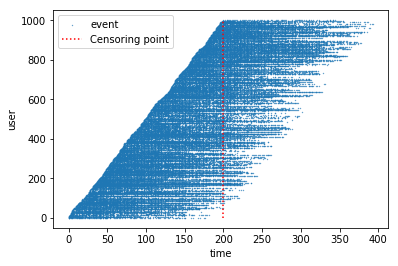

In [2]:
max_seq_length=200
starttimes_max=200
n_seqs=1000
df = generate_random_df(max_seq_length=max_seq_length,n_seqs=n_seqs,starttimes_max=starttimes_max)
df.event = 1
plt.scatter(df.dt,df.id,0.1,label='event')
plt.xlabel('time')
plt.ylabel('user')
censoring_point = starttimes_max
plt.vlines(x=censoring_point,ymin=0,ymax=n_seqs,color='red',linestyles='dotted',label = 'Censoring point')
plt.legend()
df

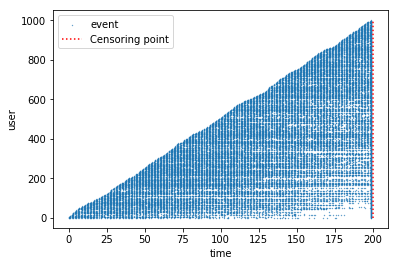

In [3]:
# Cut away what we imagine as the future:
df_subset = df[df.dt<censoring_point]
# And make sure that we - for each sequence - add a reminder of when this was 
# (i.e largest timestamp in dataset), assuming that we can't tell that sequences terminated.
df_subset = tr.df_join_in_endtime(df_subset,abs_time_col='dt',fill_zeros = True)
# As per the warning, recalculate 
df_subset['t_elapsed'] = df_subset.groupby('id', group_keys=False).apply(lambda g : g.dt - g.dt.min())

plt.scatter(df_subset.dt,df_subset.id,0.1,label='event')
plt.xlabel('time')
plt.ylabel('user')
plt.vlines(x=censoring_point,ymin=0,ymax=len(df_subset.id.unique()),color='red',linestyles='dotted',label = 'Censoring point')
plt.legend()
plt.show()

## Data to tensor & split into test/train

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


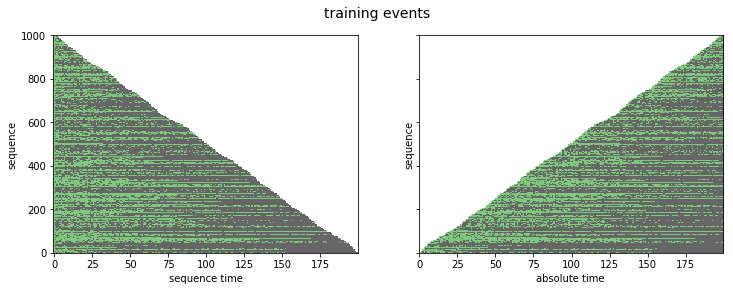

In [4]:
events_train  = tr.df_to_padded(df=df_subset,column_names=['event'],t_col='t_elapsed')
x_train       = tr.df_to_padded(df=df_subset,column_names=['event','double_column'],t_col='t_elapsed')

# As validation data pick the continuation of the sequence. 
m = df.id<=df_subset.id.max()

events_test  = tr.df_to_padded(df=df[m],column_names=['event'],t_col='t_elapsed')
x_test       = tr.df_to_padded(df=df[m],column_names=['event','double_column'],t_col='t_elapsed')

timeline_plot(np.squeeze(events_train),'training events',cmap='Accent_r');
plt.show()
# print('Testing: (sequence terminated -> no censoring -> no rightzeropadding ->plot doesnt make sense)')
# timeline_plot(np.squeeze(events_test),'testing events',cmap='Accent_r');
# plt.show()

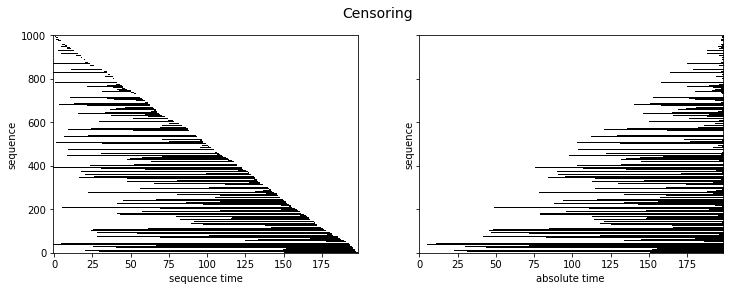

mean uncensored (train):  0.649332544355
mean uncensored (test) :  1.0
mean tte (test):          2.96526593114
max  tte (test):          134.0


In [5]:
def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.copy(np.concatenate([events,events],-1))
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*events
    return x,y,events
    
x_test,y_test,events_test   = prep_tensors(x_test,events_test)
x_train,y_train,events_train = prep_tensors(x_train,events_train)

timeline_plot(1-y_train[:,:,1],'Censoring',cmap='Greys');
plt.show()

print('mean uncensored (train): ',np.nanmean(y_train[:,:,1]))
print('mean uncensored (test) : ',np.nanmean(y_test[:,:,1]))
print('mean tte (test):         ',np.nanmean(y_test[:,:,0]))
print('max  tte (test):         ',np.nanmax(y_test[:,:,0]))

## WTTE RNN

In [6]:
def nanmask_to_keras_mask(x,y,mask_value,tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.95
    sample_weights = (x[:,:,0]!=mask_value)*1.
    return x,y,sample_weights

tte_mean_train = np.nanmean(y_train[:,:,0])
mask_value = -1.3371337 
mean_u = np.nanmean(y_train[:,:,1])

x_test,y_test,sample_weights_test    = nanmask_to_keras_mask(x_test,y_test,mask_value,tte_mean_train)
x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train,y_train,mask_value,tte_mean_train)

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

init_alpha:  30.5629154887 mean uncensored train:  0.649332544355


In [7]:

import keras.backend as K
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Masking
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras import callbacks

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=50, 
                                        verbose=0, 
                                        mode='auto', 
                                        epsilon=0.0001, 
                                        cooldown=0, 
                                        min_lr=1e-8)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False,per_epoch= True)
n_features = x_train.shape[-1]
        
def base_model():
    model = Sequential()
    model.add(Masking(mask_value=mask_value,input_shape=(None, n_features)))
    model.add(GRU(3,activation='tanh',return_sequences=True))
    return model
def wtte_rnn():
    model = base_model()

    model.add(TimeDistributed(Dense(2)))
    model.add(Lambda(wtte.output_lambda, 
                     arguments={"init_alpha":init_alpha, 
                                "max_beta_value":4.0,
                                "alpha_kernel_scalefactor":0.5}))

    loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function
    model.compile(loss=loss, optimizer=adam(lr=.01,clipvalue=0.5),sample_weight_mode='temporal')
    return model

Using Theano backend.


/usr/local/lib/python2.7/site-packages/keras/layers/core.py:633: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 2)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 3)           54        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2)           8         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 0s - loss: 2.3329 - val_loss: 2.4239
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 1.9050 - val_loss: 2.3230
Epoch 3/100
1000/1000 [===================

1000/1000 [==============================] - 0s - loss: 1.3448 - val_loss: 1.8687
Epoch 78/100
1000/1000 [==============================] - 0s - loss: 1.3479 - val_loss: 1.8581
Epoch 79/100
1000/1000 [==============================] - 0s - loss: 1.3444 - val_loss: 1.8504
Epoch 80/100
1000/1000 [==============================] - 0s - loss: 1.3453 - val_loss: 1.8725
Epoch 81/100
1000/1000 [==============================] - 0s - loss: 1.3402 - val_loss: 1.8468
Epoch 82/100
1000/1000 [==============================] - 0s - loss: 1.3393 - val_loss: 1.8605
Epoch 83/100
1000/1000 [==============================] - 0s - loss: 1.3391 - val_loss: 1.8581
Epoch 84/100
1000/1000 [==============================] - 0s - loss: 1.3376 - val_loss: 1.8598
Epoch 85/100
1000/1000 [==============================] - 0s - loss: 1.3333 - val_loss: 1.8457
Epoch 86/100
1000/1000 [==============================] - 0s - loss: 1.3377 - val_loss: 1.8528
Epoch 87/100
1000/1000 [==============================] - 0s - 

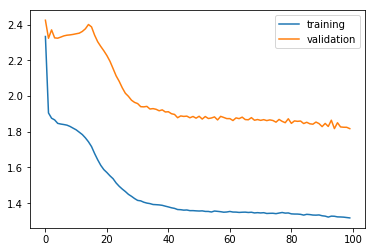

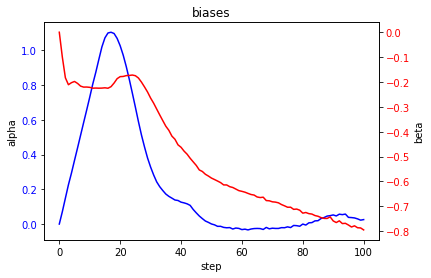

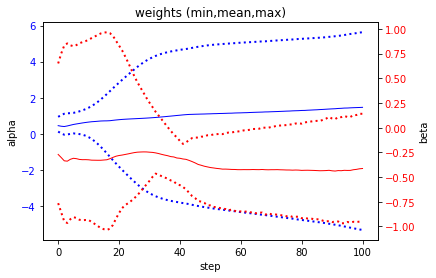

In [8]:
model = wtte_rnn()
model.summary()

K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train,
          epochs=100,
          batch_size=100, 
          verbose=1,
          validation_data=(x_test, y_test,sample_weights_test),
          sample_weight = sample_weights_train,
          callbacks=[nanterminator,history,weightwatcher,reduce_lr])

plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

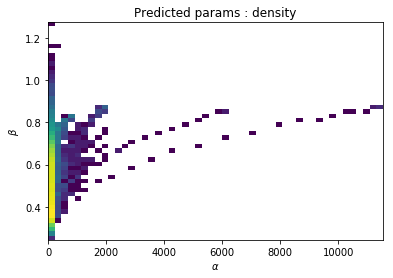

Bad Example?:


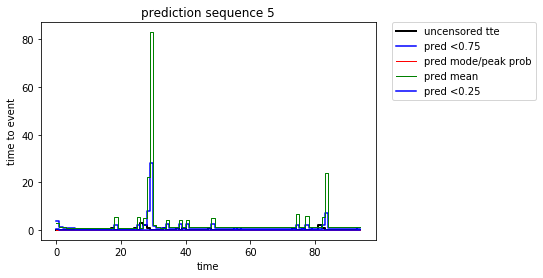

Good Example?:


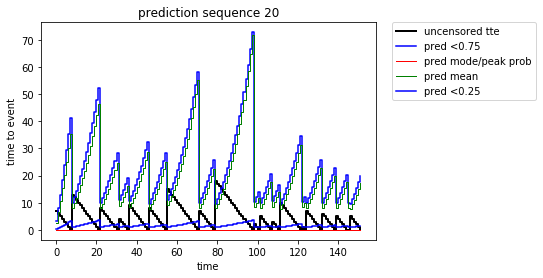

Good Example?:
alpha : mean    14.3816006448
alpha : median  1.9066599771
alpha :    min  0.145359670691
alpha :    max  11544.096695
beta  : mean    0.481790051658
beta  : median  0.46533720105
beta  :    min  0.243091841941
beta  :    max  1.27541707031


In [22]:
# Optional: add a margin of zeros at the end of the sequence to see what the 
# model does after the first events (if it identifies death by pushing prediction to inf)

mask = np.copy(x_test)
mask[mask==mask_value] = np.nan
mask = mask*0
predicted = model.predict(x_test)+mask[:,:,:1]

alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

## log-alpha typically makes more sense.
from matplotlib.colors import LogNorm
counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
plt.title('Predicted params : density')
plt.xlim([alpha_flat.min(),alpha_flat.max()])
plt.ylim([beta_flat.min(),beta_flat.max()])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

# Pick out prediction for one sequence
batch_indx = 500
print('Bad Example?:')
for batch_indx in [5,20]:
    seq_len = (~np.isnan(predicted[batch_indx,:,0])).sum()
    a = predicted[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]
    b = predicted[batch_indx,:seq_len,1]+mask[batch_indx,:seq_len,0]
    t = np.array(xrange(len(a)))+mask[batch_indx,:seq_len,0]

    tte_actual   = y_test[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]

    ##### Prediction (Using weibull-quantities like quantiles etc)
    drawstyle = 'steps-post'
    plt.plot(t,tte_actual,label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)

    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
    plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)

    #     plt.ylim(0, 2*np.nanmax(tte_actual))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.title('prediction sequence '+str(batch_indx),)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print('Good Example?:')

print('alpha : mean   ',alpha_flat.mean())
print('alpha : median ',np.median(alpha_flat))
print('alpha :    min ',alpha_flat.min())
print('alpha :    max ',alpha_flat.max())
print('beta  : mean   ',beta_flat.mean())
print('beta  : median ',np.median(beta_flat))
print('beta  :    min ',beta_flat.min())
print('beta  :    max ',beta_flat.max())


# Analysis

- The model is trained on alive and dead sequences. 
- At every step it's trying to predict tte
- It's *also* trying to predict if the sequence is dying or not i.e inifinity TTE (i.e prediction spiking to infinity)
- Very high prediction may be a feature (if were trying to identify churners), a bug (if it learns the censoring point in the dataset i.e artifact learning) or both (we want it to spike if it's a changepoint but we dont want it to spike only due to censoring or that it causes instability and numerical problems. 
- There's some pretty effective remedies for a middleway that I'll post soon
- For application to a real dataset check out `data-pipeline-template`